<a name="top"></a>

# Intermediate notebook 3: stellar rotation rates part 2
In [a previous notebook](../../07-interm_rotation_rate), we walked through the steps of inferring a relationship between the rotation rate and flaring rate of an M dwarf population. The method we used to determine the rotation rates — the Lomb-Scargle periodogram — did not produce formal errors. We're left with a few questions, then:

- what is the uncertainty on the trend we derived in the previous notebook?
- what is the *significance* of the trend we derived in the previous notebook? Can our trend be formally distinguished from a flat line?

In this notebook, we will walk through the Bayesian modeling required to answer the above questions. Additionally, we will examine a data-driven approach to modeling stellar rotation: Gaussian processes.

# Table of contents
- [Learning objectives](#Learningobjectives)
- [Prerequisites](#prereqs)
- [Import statements](#import)
- [How sinusoidal are rotating stars' light curves?](#sinusoidal)
- [Gaussian processes and rotating stars](#gps)
- [Sampling the posterior distribution](#sampling)
- [Gaussian processes for the whole population](#gaussian_pop)
- [Hierarchical Bayesian modeling](#hierarchical)
- [Hierarchical Bayesian modeling a flat line](#hierarchical_flat)
    - [Exercise 1](#exercise_1)
    - [Performing hierarchical Bayesian modeling of a flat line](#performing_flat) 
- [Model comparison](#comparison)
    - [Exercise 2](#exercise_2)
    - [Performing the model comparison](#perform_comparison)
- [Additional exercises](#more_exercises)
- [Resources](#resources)

# Learning objectives<a name="Learningobjectives"></a>
- Fit a Gaussian process to a rotating star's lightcurve.
- Understand how to apply Bayesian statistics to astrophysical problems.
- Use Bayesian statistics to determine a population-level trend for stellar rotation as a function of flare rate.
- Use Python code accelerators to speed up computation.

# Prerequisites<a name="prereqs"></a>
- Familiarity with writing functions: https://www.py4e.com/html3/04-functions
- Previous TIKE notebook: [Classifying stellar flares with stella](../../05-classify-with-ml)
- Previous TIKE notebook: [stellar rotation rates](../../07-interm_rotation_rate)

## Import Statements<a name="import"></a>

* **numpy** is used for array manipulation.

* **matplotlib.pyplot** is used to display images and plot datasets.
* **lightkurve** allows us to easily interact with TESS light curves.

In [5]:
# manipulating and plotting arrays
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import seaborn as sns
import pandas as pd

# file handling and units
import tarfile
from tqdm import tqdm
import astropy
from astropy.io import fits
import astropy.constants as const
import astropy.units as u
from astropy.utils.data import download_file
from lightkurve.search import search_lightcurve
from numba import njit

# machine learning and data packages

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from sklearn import metrics
import scipy

# now need to set up the sampling
import emcee

#setting random seeds
seed = 42
np.random.seed(seed)
import os
os.environ['PYTHONHASHSEED']=str(seed)
import random
random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)

# read from cloud datasets as opposed to downloading from on-premise servers
from astroquery.mast import Observations
Observations.enable_cloud_dataset()

# gaussian process packages
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
import arviz as az
import corner



%matplotlib inline

INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]


In [3]:
!pip install celerite2

  Using cached celerite2-0.2.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (921 kB)


In [4]:
from celerite2.theano import terms, GaussianProcess

# How sinusoidal are rotating stars' light curves?<a name="sinusoidal"></a>

In a [previous notebook](../../07-stellar-rotation), we've assessed the periodic nature of rotating stars. As mentioned above, doing so with the Lomb-Scargle periodogram did not yield error bars on the calculated periods, limiting the statistical inference that we could perform.

Another consideration with the Lomb-Scargle periodogram is that is assumes a sinusoidal form to the underlying periodic signal. Let's take a closer look at our rotating stars to determine how warranted this assumption is.

(1325.0, 1335.0)

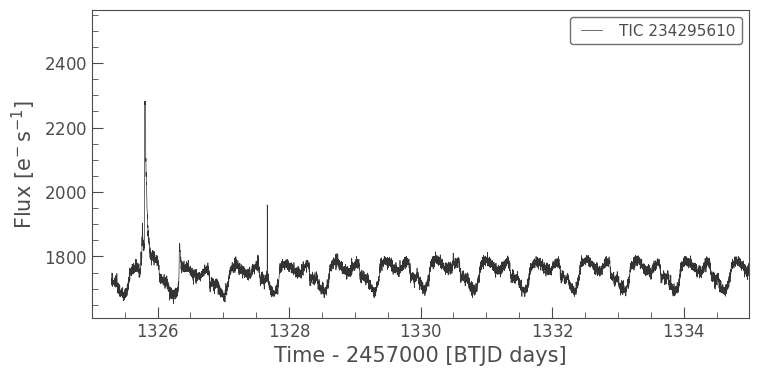

In [3]:
ticids = ['234295610']

# for all the selected targets, pull the available lightcurves using the lightkurve package
sectors = [1, 2] # only consider the first few sectors
lcs = []
for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=sectors, author='SPOC')
    lc = lc.download_all()[0]
    
lc.plot()
plt.xlim(1325, 1335)

Ignoring the flares in the dataset, there's definitely some periodic sub-structure. But is it strictly sinusoidal? Let's overplot a sinusoid, using the period we derived for this star in a [previous notebook](../../07-interm_rotation_rate). For the amplitude of the sine curve, we'll use the standard deviation of the light curve as a reasonable scale. Similarly, for the offset of the sine curve, we'll use the median value of the light curve.

(1325.0, 1335.0)

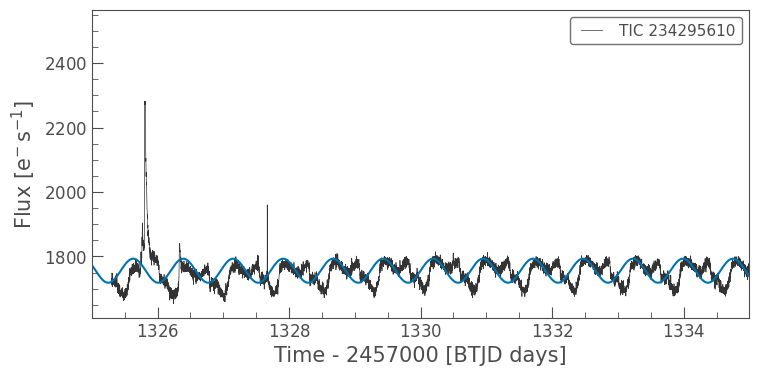

In [4]:
period_guess = 0.76 # from previous notebook

x = np.linspace(1325, 1335, 400)
y = np.median(lc.flux.value) + np.std(lc.flux.value)*np.sin(2 * np.pi  * x / period_guess)

lc.plot()
plt.plot(x,y)
plt.xlim(1325, 1335)

It looks like our previously derived period agrees with the periodicity reasonably well — at least by eye. But it's clear that there are clear departures from a sine wave in our data. The peaks in our sine wave coincide with periodic peaks in our light curve, but there is a secondary peak after the first peak in each cycle in the light curve. Our sinusoid model, by nature, cannot capture this secondary peak.

Worse yet, the "period" of this star is not strictly periodic. As described in [other notebooks](../../07-interm_rotation_rate), we can assess the rotation rate of a star because of its spotted surface: as spots rotate in and out of view, the amount of light that the observer receives proportionally varies. But spots don't live forever. Because the spot distribution on a stellar surface can therefore change, a rotating star's light curve is "quasi-periodic" (e.g., <a href="https://www.aanda.org/articles/aa/abs/2011/03/aa15877-10/aa15877-10.html">Dumusque et al. 2011</a>).

# Gaussian processes and rotating stars<a name="gps"></a>
The above limitations motivate using an alternative to the Lomb-Scargle periodogram for identifying a correlation between rotation rate and flare rate. One useful tool in this domain is a Gaussian process ([Rasmussen & Williams 05](https://link.springer.com/content/pdf/10.1007/b100712.pdf#page=71), [Angus+19](https://academic.oup.com/mnras/article/474/2/2094/4209242), [Aigrain & Foreman-Mackey 23](https://www.annualreviews.org/doi/abs/10.1146/annurev-astro-052920-103508)). 

Gaussian processes can be thought of as an extension of the multi-variate Gaussian distribution. The multivariate Gaussian distribution is defined by a mean *vector* and a *covariance matrix*. The mean vector is a collection of numbers that describe the mean value of the distribution in each of its multiple dimensions, and the covariance matrix describes how the random variables in each dimension are related to each other. Gaussian processes step beyond this: they are described by a mean *function* and a *covariance function*. In our science case, we're interested in the (quasi-periodic) correlation between points — so we want to recover the covariance function underlying a dataset.

This is a bit abstract, so let's put things into practice to gain some intuition. To do so, we'll use Gaussian processes via the [exoplanet package](https://gallery.exoplanet.codes/tutorials/stellar-variability/). First, we'll load in the rotation rates and flare rates from a [previous notebook](../../07-interm_rotation_rate) as calculated with Lomb-Scargle. We'll use the Lomb-Scargle rates as an initial guess for the Gaussian process.

In [5]:
rot_rates_constrained = np.loadtxt('rot_rates_constrained.txt')
flare_rates_durations = np.loadtxt('flare_rates_durations.txt')

First, we need to clean our dataset. We'll remove the 3 sigma outliers, and we'll grab only the first 5,000 points of our light curve. We do this to reduce the computational time.

In [6]:
lc2 = lc.remove_nans().remove_outliers()
lc2 = lc2[:5000]
_, mask = lc2.flatten().remove_outliers(sigma=3.0, return_mask=True)
lc2 = lc2[~mask]

Next, we'll recast the light curve quantities that we care about — the flux and the time stamps — into nicely formatted numpy arrays.

In [7]:
x = np.ascontiguousarray(lc2.time.value, dtype=np.float64)
y = np.ascontiguousarray(lc2.flux, dtype=np.float64)
yerr = np.ascontiguousarray(lc2.flux_err, dtype=np.float64)
mu = np.mean(y)

# center the flux around 0 for probabilistic modeling
y = (y / mu - 1) * 1e3

# perform error propagation
yerr = yerr * 1e3 / mu

Now it's time to dig into our Gaussian Process! First, we define the probabilistic model. We'll do so using the created our first [PyMC](https://www.pymc.io/welcome.html) framework. PyMC is a framework used for probabilistic modeling. We'll be using its `model` object to contain random variables in our investigation.

The entire model needs to be contained within a single `with` block. This process creates a local scope for `PyMC`, allowing it to create a graph connecting random variables.

Once the random variable container — the *model* — is ready, we now define the mean function. This function is just a Gaussian centered around 0. We're essentially making the assumption here that there is no underlying astrophysics — no signal — that we're trying to model aside from the covariance between points. 

`mean = pm.Normal("mean", mu=0.0, sigma=10.0)`

Next, we can add a "jitter" term. This term allows the model to account for more white noise than described by error bars. Every time we include a new term in this framework, we specify its *prior* distribution — that is, the distribution that encodes our understanding of that parameter's value before doing our Bayesian calculation.

`log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(yerr)), sigma=2.0)`

We can next get started actually defining the *kernel* (another word for the covariance function) of the Gaussian Process. We'll include two terms: a simple harmonic oscillator term (`SHOTerm`) and a rotation term (`RotationTerm`). The `SHOTerm` takes three arguments: sigma (the standard deviation of the process), rho (the undamped period of the oscillator), and Q (related to the damping timescale of the process). We'll define sigma and rho probabilistically so that the model can infer their values from the data. You can learn more about the `SHOTerm` in the [celerite2 documentation](https://celerite2.readthedocs.io/en/latest/api/python/) and [paper](https://iopscience.iop.org/article/10.3847/1538-3881/aa9332).

~~~

sigma = pm.InverseGamma(
        "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    )


rho = pm.InverseGamma(
    "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0)
)
~~~

With the `SHOTerm` inputs defined, we can set up the `RotationTerm`. This probabilistic term will tell us about the rotation of the star itself. We'll once more need to define a sigma of this distribution, in addition to a log period, a log Q0 (the quality factor for the secondary oscillation, which describes how damped it is), a log dQ (difference in quality factors of the first and second modes), and an f term (the fractional amplitude of the secondary mode with respect to the first). 

~~~
sigma_rot = pm.InverseGamma(
        "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
log_period = pm.Normal("log_period", mu=np.log(0.76), sigma=2.0)
period = pm.Deterministic("period", tt.exp(log_period))
log_Q0 = pm.HalfNormal("log_Q0", sigma=2.0)
log_dQ = pm.Normal("log_dQ", mu=0.0, sigma=2.0)
f = pm.Uniform("f", lower=0.1, upper=1.0)
~~~

Finally, we can add the `SHOTerm` and the `RotationTerm`, calculate the likelihood, and optimize the model.

~~~
gp = GaussianProcess(
        kernel,
        t=x,
        diag=yerr**2 + tt.exp(2 * log_jitter),
        mean=mean,
        quiet=True,
    )

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=y)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict(y))

    # Optimize to find the maximum a posteriori parameters
    map_soln = pmx.optimize(progress=True)
~~~

Let's see this all play out in the code.

In [8]:
with pm.Model() as model:
    # The mean function.
    mean = pm.Normal("mean", mu=0.0, sigma=10.0)

    # A jitter term describing excess white noise
    log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(yerr)), sigma=2.0)

    # A term to describe the non-periodic variability
    sigma = pm.InverseGamma(
        "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
    rho = pm.InverseGamma(
        "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0)
    )

    # The parameters of the RotationTerm kernel
    sigma_rot = pm.InverseGamma(
        "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
    log_period = pm.Normal("log_period", mu=np.log(0.76), sigma=2.0)
    period = pm.Deterministic("period", tt.exp(log_period))
    log_Q0 = pm.HalfNormal("log_Q0", sigma=2.0)
    log_dQ = pm.Normal("log_dQ", mu=0.0, sigma=2.0)
    f = pm.Uniform("f", lower=0.1, upper=1.0)

    # Set up the Gaussian Process model
    kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q=1 / 3.0)
    kernel += terms.RotationTerm(
        sigma=sigma_rot,
        period=period,
        Q0=tt.exp(log_Q0),
        dQ=tt.exp(log_dQ),
        f=f,
    )
    gp = GaussianProcess(
        kernel,
        t=x,
        diag=yerr**2 + tt.exp(2 * log_jitter),
        mean=mean,
        quiet=True,
    )

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=y)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict(y))

    # Optimize to find the maximum a posteriori parameters
    map_soln = pmx.optimize(progress=True)

optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -17797.54833147572 -> -15571.358082651843


We've successfully fit our first Gaussian Process! We can ignore the last error.

Let's plot the best-fitting solution against our data to see how will things match by eye.

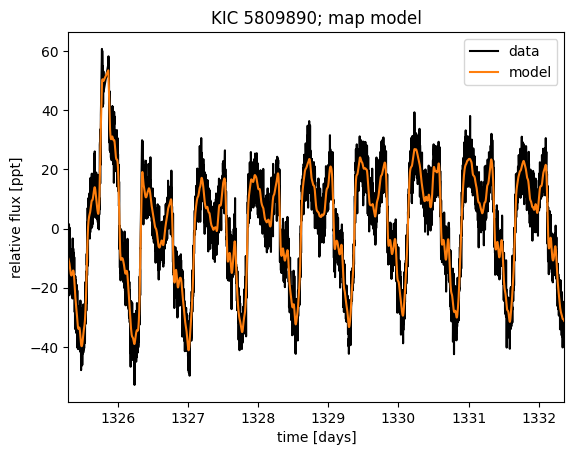

In [9]:
plt.plot(x, y, "k", label="data")
plt.plot(x, map_soln["pred"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("KIC 5809890; map model");

Nice! We're clearly capturing the non-sinusoidal variability that our sinusoid model could not. How did it actually do that, though?

To fit this model, the code optimized something known as the *posterior distribution*. Before we get into posterior distributions, let's talk about the likelihood.

In statistics, the likelihood function is a way of quantifying how well a model's parameters describe a given dataset. This tells us the probability of observing the provided dataset with a set of model parameters. As an example common likelihood function (and one that has a deep relationship to least-squares fitting; e.g., [Hogg+10](https://arxiv.org/abs/1008.4686)) is the likelihood assuming Gaussian errors:

$\mathcal{L} = \sum(\frac{(y_i - f(\theta)_i))^2}{\sigma_i^2} + \log{2\pi\sigma_i})$,

![Illustration of Bayes Theorem. The prior distribution is a Gaussian toward the left of the figure, and the likelihood is to the right. The posterior distribution lies in the middle.](bayes_sketch.png "Title")


where $\mathcal{L}$ is the likelihood, $y_i$ is an observed data point, $f$ is the model, $\theta$ are the parameters, and $\sigma_i$ are the uncertainties. The Gaussian prior likelihood that we just optimized generalizes something like this to function, instead of values.

With our likelihood in hand, we can next ask ourselves what the probability of our model is given the data. We can use Bayes' theorem to help us out:

$p(\theta|y) \propto p(x|\theta)p(\theta)$.



In plain words, the above equation reads: "The probability of these parameters given the data is proportional to the probability of the data given these parameters multiplied by the probability of these parameters." 

The likelihood is equivalent to the second term in the expression, the probability of the data given our parameters, so we substitute it in:

$p(\theta|y) \propto \mathcal{L}p(\theta)$.

So, to infer our posterior distribution — the probability of our parameters given our data, *after* performing our Bayesian calculation — we simply multiply our likelihood by our prior distribution, which we discussed above.


# Sampling the posterior distribution<a name="sampling"></a>

The above exercise has only told us the "maximum a posteriori model prediction" — which can be thought of as the best-fitting model, identifying which parameters produce the peak in the posterior distribution. But one big improvement that we wanted over the Lomb-Scargle periodogram was principled uncertainties on the period. We can calculate principled uncertainties in the Gaussian Process framework by *statistically sampling* the posterior. Essentially, this means that we will explore the likelihood function so that we can see how wide the peak is.

Ideally, we'd just calculate the full likelihood function so that we could fully flesh out all of its peaks. However, in a lot of astrophysical examples — like ours — doing that would take a really long time. So, what we do instead is use a sampler to efficiently explore the likelihood. This efficient exploration allows us to understand the shape of the posterior distribution without performing too many Gaussian Process calculations.

Luckily, we won't have to get our hands too dirty with statistical sampling yet, because pmx will do it for us (discuss more).

We'll set two different random seeds, one for each chain, so that they perform randomly differently.

We'll set 1500 steps for the `tune` stage, in which the sampler optimizes itself so it can quickly reach convergence (define convergence). After that, we'll only perform 1000 draws from the posterior (that is, we'll only perform 1000 model evaluations). The `target_accept` parameter sets how the step sizes are adjusted during the tuning phase. 

The sampling stage will initially say that it'll take a long time to converge (like 30 minutes!), but it should actually converge within ~4 minutes.

In [10]:
seed1 = 10863087
seed2 = 10863088

with model:
    trace = pmx.sample(
        tune=1500,
        draws=1000,
        start=map_soln,
        cores=4,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True,
        random_seed=[seed1, seed2],
        progressbar=True
    )

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 192 seconds.
/opt/conda/envs/tess/lib/python3.8/site-packages/arviz/utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
There were 196 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5470304937619147, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [11]:
# todo: why is there a pretty big difference between runs? check the random number instantiation.

With our sampling complete, we can use the [arviz](https://python.arviz.org/en/stable/) package to see the marginal distributions for each parameter. That is, we can see the distribution of samples for each individual parameter.

In [12]:
az.summary(
    trace,
    var_names=[
        "f",
        "log_dQ",
        "log_Q0",
        "log_period",
        "sigma_rot",
        "rho",
        "sigma",
        "log_jitter",
        "mean",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
f,0.666,0.240,0.258,0.982,0.101,0.083,6.0,649.0,1.24
log_dQ,-2.350,1.134,-4.658,-0.357,0.038,0.066,1111.0,646.0,1.31
log_Q0,0.865,1.614,0.002,3.767,1.036,0.845,4.0,19.0,1.42
log_period,-0.899,0.081,-1.025,-0.738,0.025,0.018,12.0,668.0,1.12
sigma_rot,18.489,5.514,8.478,23.907,3.512,2.856,4.0,3.0,1.42
rho,0.809,0.378,0.284,1.421,0.186,0.142,4.0,2.0,1.41
sigma,5.604,6.536,1.247,18.098,4.291,3.529,4.0,402.0,1.47
log_jitter,-1.545,1.043,-2.958,0.058,0.414,0.307,9.0,675.0,1.16
mean,0.085,2.022,-3.584,3.833,0.503,0.362,18.0,1052.0,1.09


The `mean` and `sd` columns describe the mean and standard deviation of the sampled distributions for each parameter. 

The other columns are a bit less intuitive. 
- `hdi_3%` and `hdi_97%` describe the values below which only 3% of samples lie and abeove with only 3% of samples lie, respectively. These parameters essentially tell you the spread of your samples.
- `mcse_mean` and `mcse_sd` are the Monte Carlo standard error on the mean and the Monte Carlo standard error on the standard deviation. These parameters essentially tell you how precise the mean and standard deviations of your parameters are, and therefore whether they might change between different simulations. Low values for these parameters are in general better. In our case, the `mcse_mean` and `mcse_sd` are much smaller than the mean and standard deviation of the parameter we care about — the log rotation period — so our sampling seems to have gone well.
- `ess_bulk` and `ess_tail` are used to estimate the quality of the samping, in terms of how many independent samples were produced. In principle, we want all samples to be independent draws from the posterior distribution. But many sampling techniques require different chains *walking around*, so some information about the previous step is baked into the position of the current step. These estimates describe the effective sample size in the bulk of the samples (the more dense region) and the tail of the samples (farther away from the central, dense region).
- finally, `r_hat` (also known as the Gelman-Rubin statistic) can be used to assess whether the sampler has converged. Generally, we want r_hat values less than 1.2 for convergence (cite).

todo: remove some of these columns? we don't use them later, but we could dig into them in the exercises.

Let's plot the samples for our sole parameter of interest: the stellar rotation period.

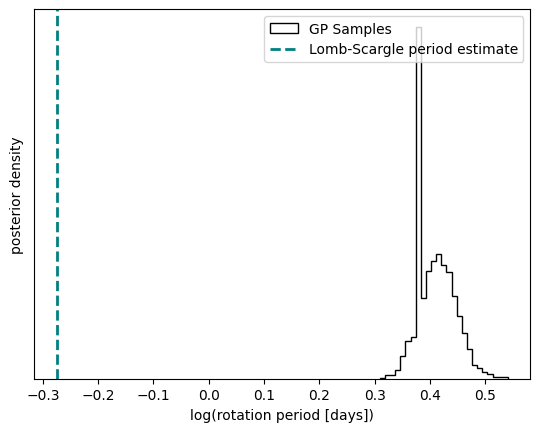

In [22]:
period_samples = np.asarray(trace.posterior["period"]).flatten()
plt.hist(period_samples, 25, histtype="step", color="k", density=True, label='GP Samples')
plt.yticks([])
plt.xlabel("log(rotation period [days])")
plt.axvline(np.log(0.76), color='teal', linestyle='--', lw=2, label='Lomb-Scargle period estimate')
_ = plt.ylabel("posterior density")
plt.legend()

Wow! It looks like Lomb-Scargle gave us a pretty different answer than the Gaussian process result. Additionally, it looks like the sampler has found significant uncertainty in the inferred rotation rate of this star. To correctly determine a relationship between rotation rate and flare rate, this uncertainty must be properly accounted for.

# Gaussian processes for the whole population<a name="gaussian_pop"></a>
Now that we've done this step for one star, let's wrap it in a function and do it for all the stars in our sample.

In [5]:
def fit_rotation_gp(name, period_init):
    sectors = [1, 2] # only consider the first few sectors
    lcs = []
    # for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=sectors, author='SPOC')
    lc = lc.download_all()[0]
    
    lc2 = lc.remove_nans().remove_outliers()
    lc2 = lc2[:5000]
    _, mask = lc2.flatten().remove_outliers(sigma=3.0, return_mask=True)
    lc2 = lc2[~mask]

    x = np.ascontiguousarray(lc2.time.value, dtype=np.float64)
    y = np.ascontiguousarray(lc2.flux, dtype=np.float64)
    yerr = np.ascontiguousarray(lc2.flux_err, dtype=np.float64)
    mu = np.mean(y)
    y = (y / mu - 1) * 1e3
    yerr = yerr * 1e3 / mu
    
    with pm.Model() as model:
        # The mean flux of the time series
        mean = pm.Normal("mean", mu=0.0, sigma=10.0)

        # A jitter term describing excess white noise
        log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(yerr)), sigma=2.0)

        # A term to describe the non-periodic variability
        sigma = pm.InverseGamma(
            "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        rho = pm.InverseGamma(
            "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0)
        )

        # The parameters of the RotationTerm kernel
        sigma_rot = pm.InverseGamma(
            "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        log_period = pm.Normal("log_period", mu=np.log(period_init), sigma=2.0)
        period = pm.Deterministic("period", tt.exp(log_period))
        log_Q0 = pm.HalfNormal("log_Q0", sigma=2.0)
        log_dQ = pm.Normal("log_dQ", mu=0.0, sigma=2.0)
        f = pm.Uniform("f", lower=0.1, upper=1.0)

        # Set up the Gaussian Process model
        kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q=1 / 3.0)
        kernel += terms.RotationTerm(
            sigma=sigma_rot,
            period=period,
            Q0=tt.exp(log_Q0),
            dQ=tt.exp(log_dQ),
            f=f,
        )
        gp = GaussianProcess(
            kernel,
            t=x,
            diag=yerr**2 + tt.exp(2 * log_jitter),
            mean=mean,
            quiet=True,
        )

        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        gp.marginal("gp", observed=y)

        # Compute the mean model prediction for plotting purposes
        pm.Deterministic("pred", gp.predict(y))

        # Optimize to find the maximum a posteriori parameters
        map_soln = pmx.optimize(progress=False)
        
    with model:
        trace = pmx.sample(
            tune=1000,
            draws=1000,
            start=map_soln,
            cores=4,
            chains=2,
            target_accept=0.9,
            return_inferencedata=True,
            random_seed=[10863087, 10863088],
            progressbar=False
        )
        
    period_samples = np.asarray(trace.posterior["period"]).flatten()
    np.save(f'period_samples{name}.npy', period_samples)
    return period_samples


    

The below code can take an hour or so to run. You can run the whole thing, or you can skip to loading in our answers. We promise that you'd arrive at the same answer!

In [ ]:
rot_rates_gp = []

# iterate though stars
for i, star in tqdm(enumerate(stars[::200]), total=len(stars[::200])):
    
    # only fit the stars with "good" flare rates.
    if flare_rates_durations<=0.0:
        rot_rates_gp += [0.0]
    star_name = str(star) # the rotation rate function takes strings
    period_guess = rot_rates_constrained[i]
    
    rot_rate_gp_samples = fit_rotation_gp(star_name, period_guess)
    
    # store result of rotation rate calculation
    rot_rates_gp += [rot_rate_gp_samples]

We can plot a few of these distributions to get a sense of scale here.

In [30]:
stars = np.loadtxt('stars.txt')

In [31]:
# if loading back in after performing the computations
rot_rates_gp = []
# iterate though stars
for star in tqdm(stars[::200]):
    star_name = str(star) # the rotation rate function takes strings
    data = np.load(f'period_samples{int(eval(star_name))}.npy')
    rot_rates_gp += [data]

100%|██████████| 44/44 [00:00<00:00, 471.69it/s]


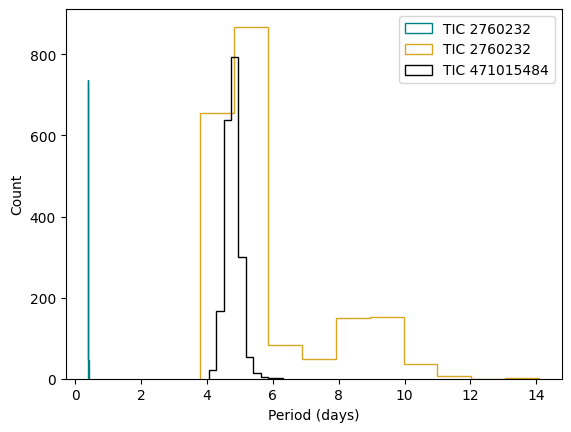

In [43]:
plt.hist(rot_rates_gp[0], label='TIC ' + str(int(stars[0])), histtype="step", color="teal", density=False)
plt.hist(rot_rates_gp[1], label='TIC ' + str(int(stars[1])), histtype="step", color="goldenrod", density=False)
plt.hist(rot_rates_gp[-1], label='TIC ' + str(int(stars[-1])),
         histtype="step", color="k", density=False)

plt.xlabel('Period (days)')
plt.ylabel('Count')
plt.legend()

It looks like there's pretty significant spread in the distributions of periods and the associated scales. Some rotation rates are very well constrained, whereas others have much wider uncertainty. This result makes it even clearer that we have to take the period uncertainties into account when looking for a population-level trend. For example, if one period value is very uncertain, we want it to influence our trend less.

# Hierarchical Bayesian modeling<a name="hierarchical"></a>

The problem at this stage is that we want to draw a line through period vs. flare rate and understand the uncertainty on that line, given uncertainties on period. But the period uncertainties are very non-trivial; note that the above-plotted distributions don't necessarily look Gaussian. How should we proceed?

The idea is to use a technique called hierarchical Bayesian modeling. This technique is used to model relationships between different levels of structured data, all of which have their own associated parameters and uncertainties. In our case, hierarchical Bayesian modeling allows us to infer, all at once and self-consistently, the uncertainties on the individual rotation rates and uncertainties on the overall trend that describes those rotation rates as a function of flare rate.

At this point, we've already gone through all the trouble of sampling the likelihood for each star to infer its rotation rate posterior distribution. Luckily, we don't have to perform a new sampling calculation from scratch. Using the statistical formulation of [Hogg et al. 2010](https://iopscience.iop.org/article/10.1088/0004-637X/725/2/2166/meta) (as also implemented in, e.g., [Lustig-Yaeger et al. 2022](https://iopscience.iop.org/article/10.3847/1538-3881/ac5034/meta)), we can use the samples we've already generated at the individual level (for each star) to perform our population-level sampling.

Now it's time to perform our hierarchical Bayesian sampling, following the prescription of [Lustig-Yaeger et al. 2022](https://iopscience.iop.org/article/10.3847/1538-3881/ac5034/meta). Note that because the likelihood function contains a nested loop, we get a few orders of magnitude speed-up by using the Numba package.

First, we'll define the hyperprior. This function tells us the prior distribution on our hyperparameters — in our case, the slope and intercept of the trend line we're fitting. All of these samples are accelerated with the `numba` package. After a function's first exection, the `@njit` decorator compiles the function down machine code to make the code faster.

In [13]:
@njit
def hyperprior(hypertheta):
    """
    Prior for the population-level trend describing the relationship between (log) flare rate and (log) rotation rate.
    
    Inputs
    ------
        :hypertheta: (array) parameters for the population-level trend.
        
    Output
    ------
        :hyperprior_val: (float) value of the prior.
    """
    
    # below is a "top hat" prior. Anything outside of the boundary returns negative infinity, and anything inside returns 0.
    m, b, sigma_2 = hypertheta
    if not (-7 < m < 7 and -10 < b < 10 and sigma_2 > 0.2):
        return -np.inf

    
    # this is a Gaussian prior. We want the value to be close to 0, so that the line is rewarded for being close to the data.
    mu = 0
    sigma = 1
    return np.log(1.0 / (np.sqrt(2 * np.pi) * sigma)) - 0.5 * (sigma_2 - mu)**2 / sigma**2

Note that we've also included a `sigma_2` parameter. This parameter basically penalizes trend lines that are too far away from the data, making sure that it doesn't stray too far away.

Next, we define `f_rotation` — the population-level trend that we're fitting. In our case, we're fitting a linear trend line to relate the log rotation rate to the log flare rate.

In [23]:
@njit
def f_rotation(m, b, flare): # just a log-linear functional form
    """
    this is the function that returns the LOG rotation rate. it encodes the population trend.
    
    Inputs
    ------
        :m: (float) slope of trend.
        :b: (float) intercept of trend.
        :flare: (float) flare rate.
    """
    return m * np.log10(flare) + b

To perform our hierarchical sampling, we'll also need to utilize the previous prior used to perform our individual-star sampling. We'll just reproduce what we implemented above in `PyMC3`: a Gaussian prior on the inferred rotation rate.

In [44]:
@njit
def previous_prior(rotation_inferred, period_guess):
    """
    The prior of a given star's rotation rate.
    the pymc3 prior is normal in log sigma. oh, this is prior, not log prior!
    """
    sigma = 2 # from rotation rate prior.
    rotation_inferred_log = np.log10(rotation_inferred)
    mu = np.log10(period_guess)
    return np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(rotation_inferred_log-mu)**2/sigma**2 

Here's where things start to get tricky. According to [the references], to see how likely a given set of hyperparameters is — that is, how likely a trend line through our population is — we need to calculate an *updated* prior based on the currently simulated population-level trend. This updated prior is a better prior for each star's rotation rate, because it will (once everything is converged) encode knowledge about the trend. It is the prior inferred from the population of stars.

In [45]:
@njit
def updated_prior(rotation_inferred, m, b, flare_rate, sigma_2):
    """
    The prior of a given star's rotation rate, updated to reflect the contribution from the population-level trend.
    """
    # this is P_alpha
    sigma = sigma_2


    return np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(np.log10(rotation_inferred)-f_rotation(m, b, flare_rate))**2/sigma**2 

Why do we care about this updated prior? It turns out that this updated prior features into the hierarchical likelihood — the likelihood of the dataset given the current set of parameters (the slope and intercept of the trend line). The computation is as follows.

1. For each star, loop over each of its period samples.
2. For each sample, calculate the updated prior and the previous prior.
3. Take the ratio of these priors. The result is the likelihood for that sample.
4. Repeat steps 2-3 for each sample.
5. Repeat steps 1-4 for each star.

[todo: explain this all better?]

In [27]:
@njit
def likelihood_hierarchical(samples, m, b, sigma_2, flare_rates_durations_cleaned, rot_rates_constrained):
    """
    The likelihood function of the population-level trend.
    
    the regular prior was normal in log period
    """
    
    
    total_likelihood = 1.
    # looping over whole populatio
    for i, rotations_inferred in enumerate(samples):
        
        # right now looping over a single planet's retrieved rotation rate
        likelihood = 0.
        flare_rate = flare_rates_durations_cleaned[i]
        period_guess = rot_rates_constrained[i]
        for rotation_inferred in rotations_inferred:
            updated_prior_val = np.exp(updated_prior(rotation_inferred, m, b, flare_rate, sigma_2))
            previous_prior_val = np.exp(previous_prior(rotation_inferred, period_guess))
            prior_update = updated_prior_val / previous_prior_val
            likelihood += prior_update

        total_likelihood *= likelihood / len(rotations_inferred)
    
    return np.log(total_likelihood)

With all the difficult statistical machinery behind us, we can now calculate the posterior of our hierarchical model: the probability of a given trend line given the data. To calculate it, all we need to do is add the log hierarchical likelihood to the log hyperprior.

In [24]:
@njit
def posterior_hierarchical(hypertheta, samples, flare_rates_durations_cleaned, rot_rates_constrained):
    """
    The posterior distribution of the population-level trend.
    
    Technically this is the probability function...change!
    """
    m, b, sigma_2 = hypertheta
    # likelihood * P_a
    
    hyperprior_val = hyperprior(hypertheta)
    
    if not np.isfinite(hyperprior_val):
        return -np.inf
    
    # error maybe in likelihood func
    likelihood_val = likelihood_hierarchical(samples, m, b, sigma_2, flare_rates_durations_cleaned, rot_rates_constrained)
    
    return likelihood_val + hyperprior_val

We're now all set up for our MCMC sampling. But where do we start the walkers? Let's instantiate them with a simple regression result.

In [47]:
# perform regression on the log values

rot_rates_gp = np.array(rot_rates_gp)

rot_rates_constrained_cleaned = rot_rates_constrained[flare_rates_durations>0.0]
rot_rates_gp_cleaned = rot_rates_gp[flare_rates_durations>0.0]
flare_rates_durations_cleaned = flare_rates_durations[flare_rates_durations>0.0]

flare_rates_durations_sorted = np.sort(np.log10(flare_rates_durations_cleaned))

rot_rates_constrained_sorted = rot_rates_constrained_cleaned[np.argsort(np.log10(flare_rates_durations_cleaned))]

rot_rates_gp_sorted = rot_rates_gp_cleaned[np.argsort(np.log10(flare_rates_durations_cleaned))]

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.log10(flare_rates_durations_sorted),
                                                                     np.log10(np.mean(rot_rates_gp_sorted, axis=1)))

print(slope, intercept)

-3.59972589382846 2.6955344949930904


Now we're ready to sample the posterior distribution! We'll use the `emcee` package to do so. `emcee` is an MCMC (Markov Chain Monte Carlo) sampler that's used to efficiently sample distributions. It begins with a number of *walkers* that step through parameter space, seeking to flesh out the posterior distribution. The paths that these walkers take are known as *chains*.

In [48]:
n_dim = 3
n_walkers = 32 # seems fine. justify?
n_steps = 5000 # seems fine. justify?


initial_point = np.array([slope, intercept, .5]) # incorporate as an array and not a list so that we can add to it, etc.
gaussian_scatter_level = 1e-3 # want the walkers to each start at a slightly different location.

# add some scatter to the walkers around the initial position.
pos = initial_point + gaussian_scatter_level * np.random.randn(n_walkers, n_dim)



sampler = emcee.EnsembleSampler(
    n_walkers, n_dim, posterior_hierarchical, args=(rot_rates_gp_sorted, flare_rates_durations_sorted,
                                                    rot_rates_constrained_sorted)
)
sampler.run_mcmc(pos, n_steps, progress=True);



100%|██████████| 5000/5000 [04:30<00:00, 18.46it/s]


Our sampling is complete! Let's take a closer look at how our walkers have explored parameter space. To do so, we can construct "trace plots," which show the path of each walker at each step. These plots are great to quickly assess if something has gone wrong with our sampling. For instance, if we accidentally initialized our walkers outside of our prior range, then they won't be able to move anywhere, and the trace plot will just show horizontal lines all the way through. Incidentally, another clue that this specific problem is occurring is that your posterior is being evaluated suspiciously quickly!

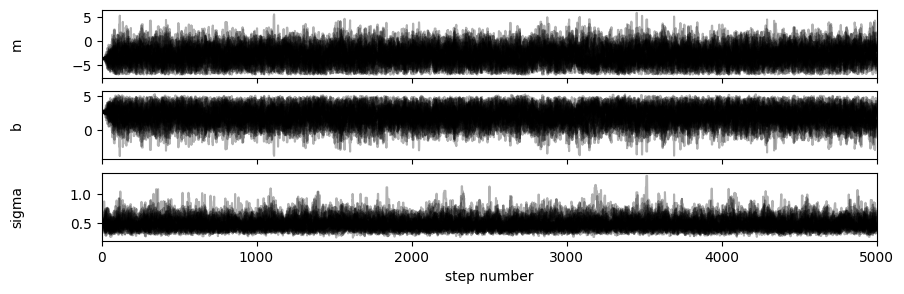

In [49]:
fig, axes = plt.subplots(n_dim, figsize=(10, 3), sharex=True)
samples = sampler.get_chain()
labels = ['m', 'b', 'sigma']

for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Nice! It looks like the walkers started out quite close to each other, but then they rapidly moved outward to explore parameter space in all three dimensions.

We mentioned that problem with correlated steps earlier, though. One way to check that our sampler has converged is that we've run our chains for a few multiples of the autocorrelation time (the number of steps in between independent samples). Let's assess whether that's the case.

In [50]:
tau = sampler.get_autocorr_time()
print(tau)

[36.48917924 36.35064027 44.82643227]


Great! Let's reshape our chains for plotting and discard a few multiples of the autocorrelation time. We also thin our chains because ___

In [53]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


Using the `corner` package, we can now visualize the marginal distributions of each parameter and see how they covary with one another.

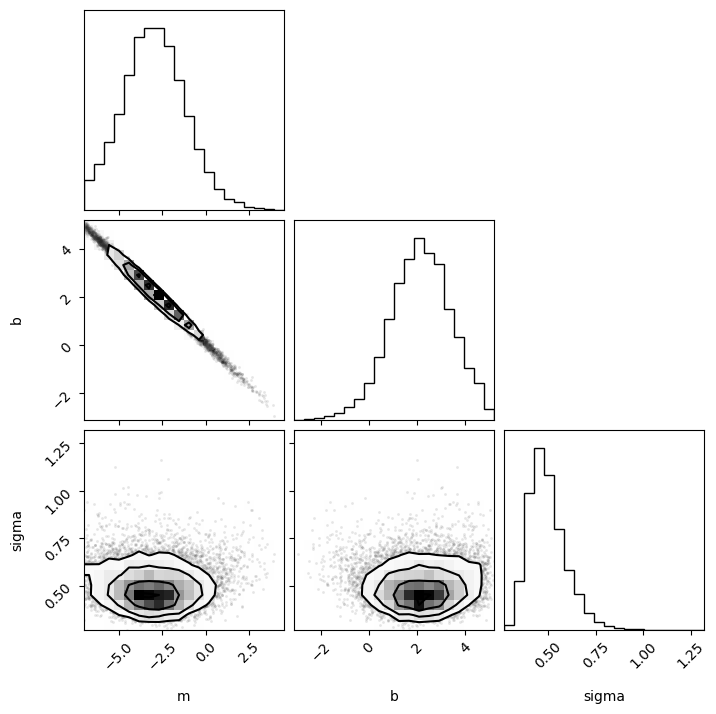

In [54]:
fig = corner.corner(
    flat_samples, labels=labels
);

It looks like the slope and intercept parameters are pretty degenerate with one another. This means that the impact on the likelihood by changing `m` a little can also be produced by changing `b` a little. More intuitively put, it means that these parameters are hard to disentangle from one another.

Let's plot up the results of all this statistical modeling in the plane we care about: flare rate vs. stellar rotation rate. 

Loosely, we can plot the error on a single rotation period as the standard deviation of its posterior distribution.

In [51]:
yerr = np.std(rot_rates_gp_sorted, axis=1)

Next, we can draw a bunch of random samples from our hyperparameter chain. Using these to plot trend lines will tell us the approximate "spread" of our trend inference.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


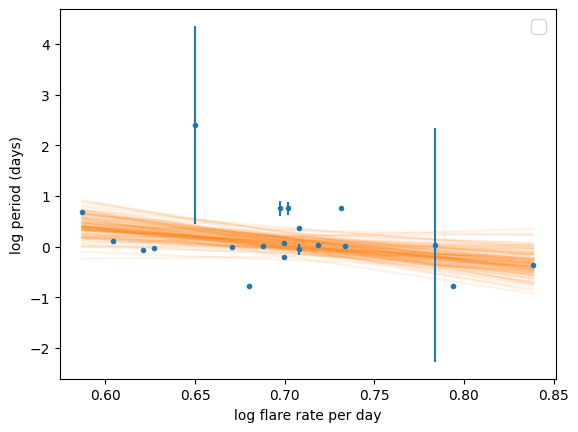

In [56]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(np.log10(flare_rates_durations_sorted), (np.dot(np.vander(np.log10(flare_rates_durations_sorted), 2), sample[:2])), "C1", alpha=0.1)
plt.errorbar(np.log10(flare_rates_durations_sorted),np.log10(np.mean(rot_rates_gp_sorted, axis=1)),
            yerr=yerr/np.mean(rot_rates_gp_sorted, axis=1) / np.log(10),fmt='.')
# plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
# plt.
plt.legend(fontsize=14)
# plt.xlim(0, 10)
plt.xlabel("log flare rate per day")
plt.ylabel("log period (days)");

Recall from earlier plots, though, that some of those rotation rate inferences did not look very Gaussian or symmetric. So, symmetric error bars like the ones we've drawn above can be a bit disingenuous. Let's use the 

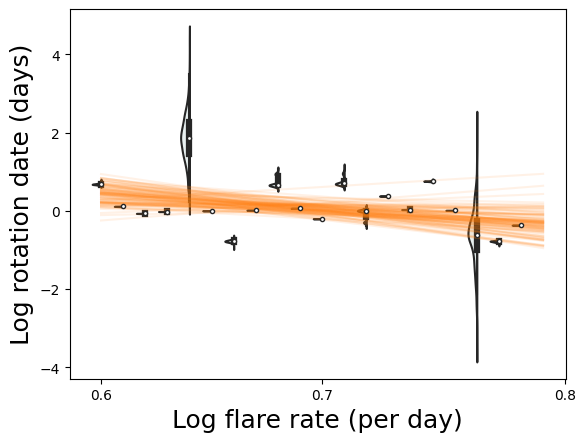

In [59]:
dat = pd.DataFrame({'flare':np.repeat(np.log10(flare_rates_durations_sorted),2000),
              'rot':np.log10(rot_rates_gp_sorted.flatten())})
fig, ax = plt.subplots()
sns.violinplot(
    data=dat,
    x="flare", y="rot", hue=True,
    hue_order=[True, False], split=True, scale_hue=12,color='teal',ax=ax
)
ax.legend_ = None
ax.set_xticks([0.,10, 21], [0.6, 0.7, 0.8])
# ax.set_yscale('log')
ax.set_xlabel('Log flare rate (per day)', fontsize=18)
ax.set_ylabel('Log rotation date (days)', fontsize=18)

inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    ax.plot(20 * (np.log10(flare_rates_durations_sorted) -0.58708446)/ (0.83866827 - 0.58708446), (np.dot(np.vander(np.log10(flare_rates_durations_sorted), 2), sample[:2])), "C1", alpha=0.1)




Nice! This plot gives us a better sense of where each stellar rotation rate's uncertainty is concentrated. To the left of each line, the distribution plotted shows the density of rotation samples for that single star. 

This plotting approach is also more accurate with respect to the trend lines, as those were calculated based on the full posterior distribution of each stellar rotation rate, instead of a single, symmetric uncertainty value.

So it looks like we can decently fit a trend line to these rotation rates. A lot of these trends, though, look pretty flat. This begs the question: How would a flat line perform against the data? Do we need the slope parameter at all?

# Hierarchical Bayesian modeling a flat line<a name="hierarchical_flat"></a>

## Exercise 1<a name="exercise_1"></a>
Implement the function `f_rotation_flat`. Like the function `f_rotation`, it calculates the population-level trend describing the relationship between the flare rate and the rotation rate. However, in `f_rotation_flat`, there is *no* relationship between the flare rate and the rotation rate. That is, the trend line is just a flat line. 

In [60]:
@njit
def f_rotation_flat(b, flare): # just a log-linear functional form
    """
    this is the function that returns the LOG rotation rate.
    """
    return b

## Performing hierarchical Bayesian modeling of a flat line<a name="performing_flat"></a>
With our new `f_rotation_flat` function implented, much of our modeling will stay the same. All we have to do us make sure we use that new equation to describe the trend line and pass fewer parameters through the rest of our functions.

In [65]:
@njit
def updated_prior_flat(rotation_inferred, b, flare_rate, sigma_2):
    # this is P_alpha
    # this should probably be log difference, right
    # mu = np.log10(rotation_inferred) - f_rotation(m, b, flare_rate) # the sample - the calculated trend. 
    sigma = sigma_2
    # pdb.set_trace()
    # return np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(np.log10(rotation_inferred)-mu)**2/sigma**2 
    return np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(np.log10(rotation_inferred)-f_rotation_flat(b, flare_rate))**2/sigma**2 

@njit
def likelihood_hierarchical_flat(samples, b, sigma_2, flare_rates_durations_cleaned, rot_rates_constrained):
    """
    the regular prior was normal in log period
    """
    total_likelihood = 1.
    # looping over whole populatio
    for i, rotations_inferred in enumerate(samples):
        # right now looping over a single planet's retrieved rotation rate
        likelihood = 0.
        flare_rate = flare_rates_durations_cleaned[i]
        period_guess = rot_rates_constrained[i]
        for rotation_inferred in rotations_inferred:
            updated_prior_val = np.exp(updated_prior_flat(rotation_inferred, b, flare_rate, sigma_2))
            previous_prior_val = np.exp(previous_prior(rotation_inferred, period_guess))
            prior_update = updated_prior_val / previous_prior_val
            likelihood += prior_update
            # if np.isnan(likelihood):
            #     pdb.set_trace()
            # if likelihood < 0:
            #     pdb.set_trace()
        total_likelihood *= likelihood / len(rotations_inferred)
    
    return np.log(total_likelihood)

@njit
def posterior_hierarchical_flat(hypertheta, samples, flare_rates_durations_cleaned, rot_rates_constrained):
    b, sigma_2 = hypertheta
    # likelihood * P_a
    
    hyperprior_val = hyperprior_flat(hypertheta)
    
    if not np.isfinite(hyperprior_val):
        return -np.inf
    
    # error maybe in likelihood func
    likelihood_val = likelihood_hierarchical_flat(samples, b, sigma_2, flare_rates_durations_cleaned, rot_rates_constrained)
    
    # if np.isnan(likelihood_val):
    #     pdb.set_trace()
    return likelihood_val + hyperprior_val


# we have all of these. now do a hyperprior.
@njit
def hyperprior_flat(hypertheta):
    b, sigma_2 = hypertheta
    if not (-10 < b < 10 and sigma_2 > 0.2):
        return -np.inf

    
    #gaussian prior on sigma_2
    mu = 0
    sigma = 1
    return np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(sigma_2-mu)**2/sigma**2

Once again, we perform our `emcee` sampling. This time, though, we only have two dimensions. We'll start our walkers at the mean of our rotation rates.

In [68]:
n_dim = 2
n_walkers = 32 # seems fine. justify?
n_steps = 5000 # seems fine. justify?


initial_point = np.array([np.mean(np.log10(rot_rates_gp_sorted)), .5]) # incorporate as an array and not a list so that we can add to it, etc.
gaussian_scatter_level = 1e-3 # seems fine. justify?

# add some scatter to the walkers around the initial position.
pos = initial_point + gaussian_scatter_level * np.random.randn(n_walkers, n_dim)



sampler = emcee.EnsembleSampler(
    n_walkers, n_dim, posterior_hierarchical_flat, args=(rot_rates_gp_sorted, flare_rates_durations_sorted,
                                                    rot_rates_constrained_sorted)
)
sampler.run_mcmc(pos, n_steps, progress=True);

100%|██████████| 5000/5000 [04:42<00:00, 17.67it/s]


Let's check the trace plots to make sure nothing funky happened in the sampling.

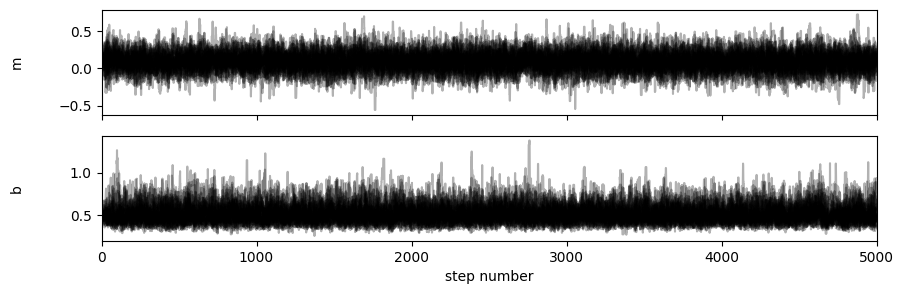

In [69]:
fig, axes = plt.subplots(n_dim, figsize=(10, 3), sharex=True)
samples = sampler.get_chain()
labels = ['m', 'b', 'sigma']

for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Things are looking pretty good. Again, we calculate our autocorrelation time and remove a few multiples of that time in steps, then plot the corner plot. 

In [71]:
tau = sampler.get_autocorr_time()
print(tau)

[30.22121036 31.29300423]


In [72]:
flat_samples_flat = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


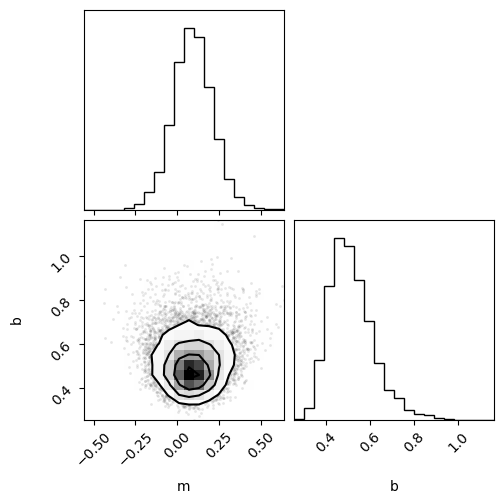

In [73]:
fig = corner.corner(
    flat_samples_flat, labels=labels
);

Looks great! Now let's plot the trend line.

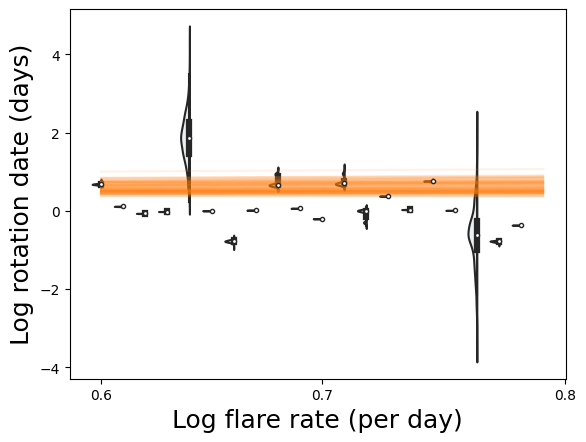

In [74]:
dat = pd.DataFrame({'flare':np.repeat(np.log10(flare_rates_durations_sorted),2000),
              'rot':np.log10(rot_rates_gp_sorted.flatten())})
fig, ax = plt.subplots()
sns.violinplot(
    data=dat,
    x="flare", y="rot", hue=True,
    hue_order=[True, False], split=True, scale_hue=12,color='teal',ax=ax
)
ax.legend_ = None
ax.set_xticks([0.,10, 21], [0.6, 0.7, 0.8])
# ax.set_yscale('log')
ax.set_xlabel('Log flare rate (per day)', fontsize=18)
ax.set_ylabel('Log rotation date (days)', fontsize=18)

inds = np.random.randint(len(flat_samples_flat), size=100)
for ind in inds:
    sample = flat_samples_flat[ind]
    ax.plot(20 * (np.log10(flare_rates_durations_sorted) -0.58708446)/ (0.83866827 - 0.58708446), (np.dot(np.vander(np.log10(flare_rates_durations_sorted), 2), sample[:2])), "C1", alpha=0.1)
# ax.errorbar(np.log10(flare_rates_durations_sorted)* 21/0.8,np.log10(np.mean(rot_rates_gp_sorted, axis=1)),
#             yerr=yerr/np.mean(rot_rates_gp_sorted, axis=1) / np.log(10),)




These flat lines also seem to do pretty well at describing the data. 

# Model comparison<a name="comparison"></a>
We now have two competing models for the relationship between flare rate and rotation rate: a flat line and a linear trend. Which one is "right"?

Philosophically, Bayesian modeling can't tell us what model underlies a given dataset. But it *can* tell us what the data prefer. That is, we can perform a model comparison exercise that tells us whether the data quality warrant a complex model or a simpler one.

This idea is based on the idea of Occam's Razor. Loosely, we don't want to use a complex idea to explain a concept when a simpler one does just as well. Mathematically, we can express this with the Bayesian Information Criterion:

BIC = $-2\mathcal{L} + k\log(N)$,

for log likelihood $\mathcal{L}$, number of parameters $k$, and number of data points $N$. This quantity captures how well a given model performs (via the likelihood), but it penalizes the model for however many parameters it uses. The difference between the BIC for two different models — the $\Delta $BIC — can therefore tell us if one model performs better than another in a way that isn't "cheating" by using too many parameters to create a better fit.

## Exercise 2<a name="exercise_2"></a>
Implement a function to calculate the Bayesian Information Criterion.

In [82]:
def calc_bic(log_likelihood, n_points, n_params):
    """
    calculates the Bayesian Information Criterion.
    """
    bic = -2 * log_likelihood + np.log(n_points) * n_params
    return bic

## Performing the model comparison<a name="perform_comparison"></a>
Now that we can calculate the BIC, let's perform the calculation on each model and take the difference.

In [83]:

n_points = len(rot_rates_gp_sorted)


# trend line likelihood
flat_chain_mean = np.mean(flat_samples, axis=0)
log_likelihood_trend = likelihood_hierarchical(rot_rates_gp_sorted, flat_chain_mean[0],
                                               flat_chain_mean[1],
                                               flat_chain_mean[2],
                                               flare_rates_durations_sorted,
                                                    rot_rates_constrained_sorted)


# flat line likelihood
flat_chain_flat_mean = np.mean(flat_samples_flat, axis=0)
log_likelihood_flat = likelihood_hierarchical_flat(rot_rates_gp_sorted, 
                                                   flat_chain_flat_mean[0], 
                                                   flat_chain_flat_mean[1], 
                                                   flare_rates_durations_sorted,
                                                    rot_rates_constrained_sorted)


# do delta BIC calculation
bic_trend = calc_bic(log_likelihood_trend, n_points, 3)
bic_flat = calc_bic(log_likelihood_flat, n_points, 2)

delta_bic = bic_trend - bic_flat
delta_bic

0.12922307812848288

We've calculated a $\Delta$BIC of 0.1. In general, we look for a $\Delta$BIC greater than 2 before we consider the data to prefer one model over the other. The rule of thumb is that anything less than 2 is "not worth more than a bare mention" (per [Kass & Rafter 1993](https://www.tandfonline.com/doi/abs/10.1080/01621459.1995.10476572?casa_token=79jMtuYH2oIAAAAA:nGzwyhOOBoVciRDbetSj3gTMy1DMmb86Ubavmd456g5eYX0eM7ftmVO_w8SEJ6laqomgXvEnnCmGeg)). The intuition here is that the trend line only does a little bit better at fitting the data than a flat line, and it needs a whole extra parameter to do so. Therefore, we might as well say that a flat line describes the data as well as a trend line.

That's a long way of saying that the trend we found was not statistically significant — even though it aligned with our predictions!

Importantly, that's not to say that our approach is flawed, or that there isn't an actual underlying trend. It may be that further observations could help us differentiate between a trend and a flat line.

Note: full Bayesian model comparison involves calculating a quantity known as the Bayesian evidence. This is usually a tricky thing to do, and in our case it likely isn't warranted given how small the $\Delta$BIC is.

# Additional exercises<a name="more_exercises"></a>
3. Perform the above but for a half-tailed Gaussian distribution. Is a flat line still a better fit?
4. Based on the Gelman-Rubin statistic, it may be that our Gaussian process isn't fully converged. Explore whether the convergence statistics improve with more draws from the posterior distribution or by changing the tuning-related parameters.

# Resources<a name="resources"></a>
- Gaussian Process review: [Rasmussen & Williams 05](https://link.springer.com/content/pdf/10.1007/b100712.pdf#page=71)
- Application of Gaussian Processes to stellar rotation: [Angus+19](https://academic.oup.com/mnras/article/474/2/2094/4209242)
- Gaussian Processes in astronomy review: [Aigrain & Foreman-Mackey 23](https://www.annualreviews.org/doi/abs/10.1146/annurev-astro-052920-103508))
- `exoplanet` tutorial on stellar variability: https://gallery.exoplanet.codes/tutorials/stellar-variability/
- `emcee` tutorial on line-fitting, with sampling introduction: https://emcee.readthedocs.io/en/stable/tutorials/line/
- guide for Bayesian inference in astronomy: https://arxiv.org/pdf/2302.04703.pdf
- review on model-fitting: https://arxiv.org/abs/1008.4686
- `celerite2` documentation: https://celerite2.readthedocs.io/en/latest/
- `pymc3` documentation: https://www.pymc.io/projects/docs/en/v5.8.1/learn/core_notebooks/pymc_overview.html

## About this Notebook

**Author:** Arjun Savel

**Last updated:** September 2023 <br>

For support, please contact the Archive HelpDesk at archive@stsci.edu.

***

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>

[Return to top of page](#top)